In [11]:
import sys
import torch
from stlkernel import kernel, formulae, trajectories, krr, kfold_cv
import matplotlib.pyplot as plt
from torcheck import stl

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
def compute_expected_rho(formulae, trajs):
    with torch.no_grad():
        y = torch.tensor([
            f.quantitative(trajs, normalize=True).mean()
            for f in formulae
        ], device=device)
    return y

In [13]:
f0 = formulae.F0(n_vars=1)
formulae_train = f0.sample(n_formulae=100)
formulae_test  = f0.sample(n_formulae=50)

In [14]:
mu0 = trajectories.Mu0(device=device)
trajectory_sampler = lambda n: mu0.sample(n_trajectories=n, n_vars=1)
trajs, time_steps = trajectory_sampler(1000)

In [15]:
target_trajs, time_steps = trajectory_sampler(500)
y_train = compute_expected_rho(formulae_train, target_trajs)
y_test  = compute_expected_rho(formulae_test, target_trajs)

In [16]:
kfold_cv.tune_stl_krr(
    trajs, 
    formulae_train, 
    y_train,
    kernel_type = 'gaussian',
    alphas=[1e-3, 1e-2, 1e-1], 
    sigmas=[0.5, 0.8, 1.0, 1.5, 2.0], 
    n_splits=3,
    cache_dir = "/share/ai-lab/adsiega/stlkrr_tests",
    device=device
)

Starting Grid Search on 15 combinations...
Best Params: {'alpha': 0.01, 'sigma': 0.8} | MSE: 0.00105


{'alpha': 0.01, 'sigma': 0.8}

In [ ]:
best_params=kfold_cv.tune_stl_krr(
    trajs, 
    formulae_train, 
    y_train,
    kernel_type = 'k_prime',
    alphas=[1e-4, 1e-3, 1e-2], 
    sigmas=[1.0], 
    n_splits=3,
    cache_dir = "/share/ai-lab/adsiega/stlkrr_tests",
    device=device
)

Starting Grid Search on 1 combinations...
Best Params: {'alpha': 0.01, 'sigma': 1.0} | MSE: 0.00013


In [19]:
best_params

{'alpha': 0.0001, 'sigma': 1.0}

In [38]:
krr_model = krr.STLKernelRidgeRegression(
    trajectories=trajs,
    kernel_type='k_prime',
    sigma=1.7,
    cache_dir = "/share/ai-lab/adsiega/stlkrr_tests",
    device=device
)

In [39]:
krr_model.fit(formulae_train, y_train)
y_pred = krr_model.predict(formulae_test)

In [40]:
mse = torch.mean((y_test - y_pred) ** 2)
print(f"MSE: {mse:.4f}")

MSE: 0.0000


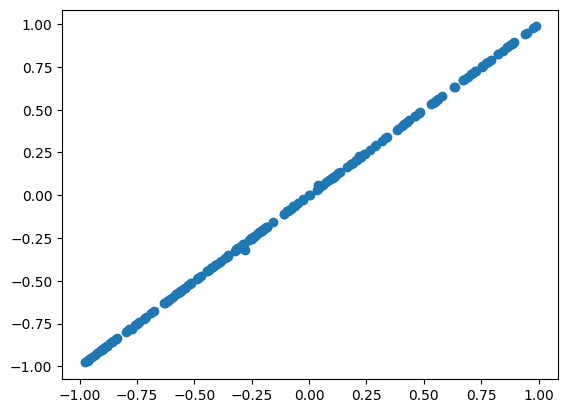

In [41]:
plt.scatter(y_pred.cpu(), y_test.cpu())
plt.show()